In [1]:
from abc import ABC, abstractmethod
from datetime import datetime
from datetime import timedelta
from collections import defaultdict
from timeit import default_timer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import math
import random
from random import sample

In [2]:
class TimeConstraint:
    """
    TimeConstraint is a constraint on the timestamp of the movie ratings.
    We classify a TimeConstraint as either max_time_constraint or time_bin_constraint.
    max_time_constraint is used to simulate real life in which we do not know the future but all the data up until one point in time.
    time_bin_constraint is used to grab a portion of a time interval where starting and ending points are strictly defined and data is well known.
    """
    
    def __init__(self, end_dt, start_dt=None):
        """
        When end_dt is only given, system will have a max time constraint only.

        When end_dt and start_dt are given, system will have beginning end ending boundary.

        :param end_dt: The maximum limit of the time constraint.
        :param start_dt: The minimum limit of the time constraint.
            Always set start_dt to None if you change the object from time_bin to max_limit.
        """
        self.end_dt = end_dt
        self.start_dt = start_dt

    def is_valid_time_bin(self) -> bool:
        """
        Check whether this TimeConstraint object represents a valid time bin.
        """
        if self.is_time_bin() and (self._end_dt > self._start_dt):
            return True
        return False

    def is_valid_max_limit(self) -> bool:
        """
        Check whether this TimeConstraint represents a valid max time limit.
        """
        if (self._end_dt is not None) and (self._start_dt is None):
            return True

    def is_time_bin(self) -> bool:
        if (self._start_dt is not None) and (self._end_dt is not None):
            return True
        return False

    # Comparing TimeConstraints

    def __eq__(self, other):
        if other is None:
            return False
        return self._start_dt == other.start_dt and self._end_dt == other.end_dt

    def __ne__(self, other):
        if other is None:
            return False
        return self._start_dt != other.start_dt or self._end_dt != other.end_dt

    # Properties

    @property
    def end_dt(self):
        return self._end_dt

    @end_dt.setter
    def end_dt(self, value):
        self._end_dt = value

    @property
    def start_dt(self):
        return self._start_dt

    @start_dt.setter
    def start_dt(self, value):
        self._start_dt = value

    # Printing TimeConstraints

    def __repr__(self):
        return f"(start = {self._start_dt}, end= {self._end_dt})"

    def __str__(self):
        return f"(start = {self._start_dt}, end= {self._end_dt})"


In [3]:
class Cache:
    """
    Cache is introduced as a way to speed up the bulk analysis. In a normal recommendations, this class should not exist.
    """
    
    def __init__(self,
                 is_ratings_cached=False,
                 ratings=None,
                 is_movies_cached=False,
                 movies=None,
                 is_movie_ratings_cached=False,
                 movie_ratings=None,
                 is_user_movie_matrix_cached=False,
                 user_movie_matrix=None,
                 is_user_correlations_cached=False,
                 user_correlations=None,
                 min_common_elements=5,
                 use_avg_ratings_cache=True):
        """ Cached data is only valid when the boolean specifier is True """

        # 30% performance
        self.is_ratings_cached = is_ratings_cached
        self.ratings = ratings

        # 7 fold performance gain on 'movie' related queries
        self.is_movies_cached = is_movies_cached
        self.movies = movies

        self.is_movie_ratings_cached = is_movie_ratings_cached
        self.movie_ratings = movie_ratings

        self.is_user_movie_matrix_cached = is_user_movie_matrix_cached
        self.user_movie_matrix = user_movie_matrix

        self.is_user_correlations_cached = is_user_correlations_cached
        self.user_correlations = user_correlations

        self.min_common_elements = min_common_elements

        # if we use avg ratings cache, on average 10 fold performance gain
        self.use_avg_ratings_cache = use_avg_ratings_cache
        if self.use_avg_ratings_cache:
            self.avg_user_ratings = self.create_user_avg_rating_cache()
        else:
            self.avg_user_ratings = None

    def create_user_avg_rating_cache(self):
        if self.is_ratings_cached:
            data = self.ratings
        else:
            data = self.movie_ratings
        return data.groupby('user_id')[['rating']].mean()

    def get_user_corrs(self, min_common_elements, time_constraint=None):
        """
        If cache enabled and matches, returns the cache, else none
        :param min_common_elements: min common element in between users in order them to become neighbours
        :param time_constraint: used in temporal caches only(used in subclass)
        :return: user correlation matrix if cache hit, else None
        """
        if self.is_user_correlations_cached:
            if self.min_common_elements == min_common_elements:
                return self.user_correlations
        return None

    # Properties
    @property
    def ratings(self):
        return self._ratings

    @ratings.setter
    def ratings(self, value):
        self._ratings = value

    @property
    def movies(self):
        return self._movies

    @movies.setter
    def movies(self, value):
        self._movies = value

    @property
    def movie_ratings(self):
        return self._movie_ratings

    @movie_ratings.setter
    def movie_ratings(self, value):
        self._movie_ratings = value

    @property
    def user_movie_matrix(self):
        return self._user_movie_matrix

    @user_movie_matrix.setter
    def user_movie_matrix(self, value):
        self._user_movie_matrix = value

    @property
    def user_correlations(self):
        return self._user_correlations

    @user_correlations.setter
    def user_correlations(self, value):
        self._user_correlations = value

    @property
    def min_common_elements(self):
        return self._min_common_elements

    @min_common_elements.setter
    def min_common_elements(self, value):
        self._min_common_elements = value


class TemporalCache(Cache):

    def __init__(self,
                 time_constraint: TimeConstraint,
                 is_ratings_cached=False,
                 ratings=None,
                 is_movies_cached=False,
                 movies=None,
                 is_movie_ratings_cached=False,
                 movie_ratings=None,
                 is_user_movie_matrix_cached=False,
                 user_movie_matrix=None,
                 is_user_correlations_cached=False,
                 user_correlations=None,
                 min_common_elements=5,
                 use_avg_ratings_cache=True,
                 use_bulk_corr_cache=True):

        super().__init__(is_ratings_cached=is_ratings_cached,
                         ratings=ratings,
                         is_movies_cached=is_movies_cached,
                         movies=movies,
                         is_movie_ratings_cached=is_movie_ratings_cached,
                         movie_ratings=movie_ratings,
                         is_user_movie_matrix_cached=is_user_movie_matrix_cached,
                         user_movie_matrix=user_movie_matrix,
                         is_user_correlations_cached=is_user_correlations_cached,
                         user_correlations=user_correlations,
                         min_common_elements=min_common_elements,
                         use_avg_ratings_cache=use_avg_ratings_cache)

        self.time_constraint = time_constraint
        self.use_bulk_corr_cache = use_bulk_corr_cache
        self.user_corrs_in_bulk = None

    def is_temporal_cache_valid(self):
        # No TimeConstraint, valid
        if self._time_constraint is None:
            return True
        # Bin TimeConstraint or Max Limit TimeConstraint, valid
        if self._time_constraint.is_valid_time_bin() or self._time_constraint.is_valid_max_limit():
            return True
        # Else, Not Valid
        return False

    def get_user_corrs_from_bulk(self, min_common_elements, time_constraint, bin_size):
        if ((self.user_corrs_in_bulk is None) or (self.user_corrs_in_bulk is None)
                or (time_constraint is None) or self.min_common_elements != min_common_elements):
            return None

        if time_constraint.is_valid_max_limit():
            return self.user_corrs_in_bulk.get(time_constraint.end_dt.year)

        if bin_size == -1:
            return None

        bins = self.user_corrs_in_bulk.get(bin_size)
        if bins is not None:
            return bins.get(time_constraint.start_dt.year)

    def get_user_corrs(self, min_common_elements, time_constraint=None):
        """
        If corrs are cached returns the cache, else None

        :param min_common_elements: min common element in between users in order them to become neighbours
        :param time_constraint: time constraint on user correlations
        :return: user correlation matrix if cache found, else None
        """
        if self.is_user_correlations_cached:
            if self.time_constraint == time_constraint and self.min_common_elements == min_common_elements:
                return self.user_correlations
        return None

    def set_user_corrs(self, user_corrs, min_common_elements, time_constraint):
        # Only set when caching is open for user_correlations
        if self.is_user_correlations_cached:
            self._time_constraint = time_constraint
            self.min_common_elements = min_common_elements
            self.user_correlations = user_corrs

    @property
    def time_constraint(self):
        return self._time_constraint

    @time_constraint.setter
    def time_constraint(self, value):
        self._time_constraint = value


In [4]:
class Accuracy:
    """
    Accuracy class provides utility methods in order to measure accuracy of our analysis.
    
    Supported Measures:
    rmse, accuracy, balanced accuracy, informedness, markedness, 
    f1, mcc, precision, recall, specificity, NPV and 
    other threshold measures where we round ratings less than 3.5 to min rating, upper to max rating and use supported measures on this data.
    """
    
    @staticmethod
    def rmse(predictions) -> float:
        """
        Calculate Root Mean Square Error of given list or Dataframe of (prediction, actual) data.
        
        In case rmse value is found 0, it is returned as 0.001 to differentiate between successfull rmse
        calculation and erroneous calculations where number of predictions in data is zero.
        """
        
        # In case dataframe of predictions wher each row[0]=prediction, row[1]=actual rating
        if type(predictions) is pd.DataFrame:
            number_of_predictions = 0
            sum_of_square_differences = 0.0
            for row in predictions.itertuples(index=False):
                prediction = row[0]
                # In case valid prediction is made(0 is invalid, minimum 0.5 in movielens dataset)
                if prediction != 0:
                    # Round the ratings to the closest half or exact number
                    # since movielens dataset only containst ratings 0.5, 1, 1.5,..., 4, 4.5, 5
                    actual = Accuracy.half_round_rating(row[1])
                    prediction = Accuracy.half_round_rating(prediction)
                    
                    sum_of_square_differences += (actual - prediction) ** 2
                    number_of_predictions += 1
                
                if number_of_predictions == 0:
                    return 0 
                rmse_value = sum_of_square_differences / number_of_predictions
            return rmse_value if rmse_value != 0 else 0.001
        # In case list of predictions where each element is (prediction, actual)
        elif type(predictions) is list:
            number_of_predictions = 0
            sum_of_square_differences = 0.0
            for prediction, actual in predictions:
                if prediction != 0:                  # if the prediction is valid
                    actual = Accuracy.half_round_rating(actual)
                    prediction = Accuracy.half_round_rating(prediction)
                    
                    sum_of_square_differences += (actual - prediction) ** 2
                    number_of_predictions += 1
                
            if number_of_predictions == 0:
                return 0
        
            rmse_value = sum_of_square_differences / number_of_predictions 
            return rmse_value if rmse_value != 0 else 0.001    
        return 0
    
    @staticmethod
    def threshold_accuracy(predictions) -> float:
        """
        Threshold accuracy is the rate of sucessful prediction when we round 
        ratings between 0.5 and 3.5 to the lowest rating(0.5) ,
        ratings between 3.5 and 5 to the highest rating(5)
        
        Accuracy = (TP + TN) / (TP + TN + FP + FN)
        
        """
        
        if type(predictions) is pd.DataFrame:
            number_of_predictions = 0
            number_of_hit = 0
            for row in predictions.itertuples(index=False):
                # row[1] : actual rating, row[0] : prediction
                prediction = row[0]
                if prediction != 0:
                    actual = Accuracy.threshold_round_rating(row[1])
                    prediction = Accuracy.threshold_round_rating(prediction)
                    
                    if actual == prediction:
                        number_of_hit += 1
                    number_of_predictions += 1
            return number_of_hit / number_of_predictions if number_of_predictions != 0 else 0
        elif type(predictions) is list:            
            number_of_predictions = 0
            number_of_hit = 0
            for prediction, actual in predictions:
                if prediction != 0:
                    actual = Accuracy.threshold_round_rating(actual)
                    prediction = Accuracy.threshold_round_rating(prediction)
                    
                    if actual == prediction:
                        number_of_hit += 1
                        
                    number_of_predictions += 1
            return number_of_hit / number_of_predictions if number_of_predictions != 0 else 0
        return 0
    
    @staticmethod
    def threshold_analize(predictions):
        """
        Analize the threshold predictions with all metrics found in the Accuracy class.
        """
        
        TP, FN, FP, TN = Accuracy.threshold_confusion_matrix(predictions)
        precision = Accuracy.precision(TP, FP)     # also called PPV
        recall = Accuracy.recall(TP, FN)           # also called TPR
        specificity = Accuracy.specificity(FP, TN) # also called TNR
        NPV = Accuracy.negative_predictive_value(FN, TN)
        
        accuracy = Accuracy.accuracy(TP, FN, FP, TN)
        balanced_accuracy = Accuracy.balanced_accuracy(TPR=recall, TNR=specificity)
        informedness = Accuracy.informedness(TPR=recall, TNR=specificity)
        markedness = Accuracy.markedness(PPV=precision, NPV=NPV)
        
        f1 = Accuracy.f_measure(precision, recall)
        mcc = Accuracy.mcc(TP, FN, FP, TN)
        
                
        output = {
                  "accuracy"         :round(accuracy, 3),
                  "balanced_accuracy":round(balanced_accuracy, 3),
                  "informedness"     :round(informedness, 3),
                  "markedness"       :round(markedness, 3),
                  "f1"               :round(f1, 3),
                  "mcc"              :round(mcc, 3),
                  "precision"        :round(precision, 3),
                  "recall"           :round(recall, 3),
                  "specificity"      :round(specificity, 3),
                  "NPV"              :round(NPV, 3)
                 }
        
        return output
    
    @staticmethod
    def analize(predictions):
        """
        Analize the threshold predictions with all metrics found in the Accuracy class.
        
        https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
        
        Returns analysis for each class as list
        :return: accuracy, balanced_accuracy, informedness, markedness, f1, mcc, precision, recall, specificity, NPV
        """
        confusion_mtr = Accuracy.confusion_matrix(predictions)
        
        # Use macro averaging (https://stats.stackexchange.com/questions/187768/matthews-correlation-coefficient-with-multi-class)
        precision = [0] * 10   # 10 is the number of classes found 
        recall = [0] * 10      # 0.5 -> Class 0 , 1 -> Class 1, 1.5 -> Class 2 .... 
        specificity = [0] * 10
        NPV = [0] * 10 
        
        accuracy = [0] * 10 
        balanced_accuracy = [0] * 10 
        informedness = [0] * 10 
        markedness = [0] * 10 
        
        f1 = [0] * 10 
        mcc = [0] * 10
        
        for i in range(0, 10): # For Each Class
            TP, FN, FP, TN = Accuracy.confusion_matrix_one_against_all(confusion_mtr, i)
            precision[i] = Accuracy.precision(TP, FP)     # also called PPV
            recall[i] = Accuracy.recall(TP, FN)           # also called TPR
            specificity[i] = Accuracy.specificity(FP, TN) # also called TNR
            NPV[i] = Accuracy.negative_predictive_value(FN, TN)

            accuracy[i] = Accuracy.accuracy(TP, FN, FP, TN)
            balanced_accuracy[i] = Accuracy.balanced_accuracy(TPR=recall[i], TNR=specificity[i])
            informedness[i] = Accuracy.informedness(TPR=recall[i], TNR=specificity[i])
            markedness[i] = Accuracy.markedness(PPV=precision[i], NPV=NPV[i])

            f1[i] = Accuracy.f_measure(precision[i], recall[i])
            mcc[i] = Accuracy.mcc(TP, FN, FP, TN)
        
        output = {
                  "accuracy"         :Accuracy.round_list_elements(accuracy, 3),
                  "balanced_accuracy":Accuracy.round_list_elements(balanced_accuracy, 3),
                  "informedness"     :Accuracy.round_list_elements(informedness, 3),
                  "markedness"       :Accuracy.round_list_elements(markedness, 3),
                  "f1"               :Accuracy.round_list_elements(f1, 3),
                  "mcc"              :Accuracy.round_list_elements(mcc, 3),
                  "precision"        :Accuracy.round_list_elements(precision, 3),
                  "recall"           :Accuracy.round_list_elements(recall, 3),
                  "specificity"      :Accuracy.round_list_elements(specificity, 3),
                  "NPV"              :Accuracy.round_list_elements(NPV, 3)
                 }
        
        return output
    
    @staticmethod
    def round_list_elements(l, precision):
        """
        :param l: list of floats
        :param precision: precision after dot
        """
        return [ round(x, precision) for x in l ]
    
    @staticmethod
    def accuracy_multi_class(confusion_mtr):
        length = len(confusion_mtr)
        numenator = 0
        denuminator = 0 
        for i in range(length):
            for j in range(length):
                temp = confusion_mtr[i][j]
                denuminator += temp
                if i == j:
                    numenator += temp
        return numenator / denominator
    
    @staticmethod
    def accuracy(TP, FN, FP, TN):
        return  (TP + TN) / (TP + FN + FP + TN)
    
    @staticmethod
    def balanced_accuracy(TPR, TNR):
        """
        :param TPR : True Positive Rate or recall or sensitivity
        :param TNR : True Negative Rate or specificity or  selectivity
        """
        return (TPR + TNR) / 2
    
    @staticmethod
    def informedness(TPR, TNR):
        """
        :param TPR : True Positive Rate or recall or sensitivity
        :param TNR : True Negative Rate or specificity or  selectivity
        """
        return TPR + TNR - 1
    
    @staticmethod
    def markedness(PPV, NPV):
        """
        :param PPV: Positive Predictive Value also known as precision
        :param NPV: Negative Predictive Value
        """
        return PPV + NPV - 1 
    
    @staticmethod
    def precision(TP, FP):
        """
        Also called as precision or positive predictive value (PPV)
        
        Precision = TP / (TP + FP) for binary class
        Precision = TP / (All Predicted Positive) for multi class
        """
        denuminator = TP + FP
        return TP / denuminator if denuminator != 0 else 0

    @staticmethod
    def negative_predictive_value(FN, TN):
        """     
        NPV = TN / (TN + FN) for binary class
        NPV = TN / (All Predicted Negative) for multi class
        """
        denuminator = TN + FN
        return TN / denuminator if denuminator != 0 else 0    
    
    @staticmethod
    def recall(TP, FN):
        """
        Also called as sensitivity, recall, hitrate, or true positive rate(TPR)
        Recall = TP / (TP + FN) for binary class
        Recall = TP / (All Actual Positive) for multi class
        """
        denuminator = TP + FN
        return TP / denuminator if denuminator != 0 else 0    
    
    @staticmethod
    def specificity(FP, TN):
        """
        Also called as specificity, selectivity or true negative rate (TNR)
        specificity = TN / (TP + FN) for binary class
        specificity = TN / (All Actual Negative) for multi class
        """
        denuminator = FP + TN 
        return TN / denuminator if denuminator != 0 else 0 
    
    @staticmethod
    def f_measure(precision, recall):
        """
        F-Measure is the harmonic mean of the precision and recall.
        """
        sum_of_both = precision + recall
        return (2 * precision * recall) / sum_of_both if sum_of_both != 0 else 0
    
    @staticmethod
    def mcc(TP, FN, FP, TN):
        """
        MCC(Matthews Correlation Coefficient)
        """
        # Calulate Matthews Correlation Coefficient
        numenator   = (TP * TN) - (FP * FN) 
        denominator = (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)
        denominator = math.sqrt(denominator) if denominator > 0 else 0
        return numenator / denominator if denominator != 0 else 0
  
# deprecated -> now, we use macro averaging instad of multi class versions of metrics
#     @staticmethod
#     def mcc_multi_class(confusion_mtr):
#         # https://en.wikipedia.org/wiki/Matthews_correlation_coefficient#Multiclass_case
#         # https://stats.stackexchange.com/questions/187768/matthews-correlation-coefficient-with-multi-class
#         length = len(confusion_mtr)
#         numenator = 0
#         for k in range(length):
#             for l in range(length):
#                 for m in range(length):
#                     numenator += confusion_mtr[k][k] * confusion_mtr[l][m]
#                     numenator -= confusion_mtr[k][l] * confusion_mtr[m][k]

#         denuminator_1 = 0
#         for k in range(length):
#             denuminator_part_1 = 0
#             for l in range(length):
#                 denuminator_part_1 += confusion_mtr[k][l]

#             denuminator_part_2 = 0
#             for f in range(length):
#                 if f != k:
#                     for g in range(length):
#                         denuminator_part_2 += confusion_mtr[f][g]
#             denuminator_1 += denuminator_part_1 * denuminator_part_2

#         denuminator_2 = 0
#         for k in range(length):
#             denuminator2_part_1 = 0
#             for l in range(length):
#                 denuminator2_part_1 += confusion_mtr[l][k]

#             denuminator2_part_2 = 0
#             for f in range(length):
#                 if f != k:
#                     for g in range(length):
#                         denuminator2_part_2 += confusion_mtr[g][f]
#             denuminator_2 += denuminator2_part_1 * denuminator2_part_2
#         return numenator / math.sqrt(denuminator_1) * math.sqrt(denuminator_2)
    
    @staticmethod
    def confusion_matrix_one_against_all(confusion_mtr, class_i):
        """
        Create binary confusion matrix out of multi-class confusion matrix
        
        Positive Class: class_i
        Negative Class: non class_i
                
        TP: True Positive   FN: False Negative
        FP: False Positive  TN: True Negative
        
        "TP of Class_1" is all Class_1 instances that are classified as Class_1.
        "TN of Class_1" is all non-Class_1 instances that are not classified as Class_1.
        "FP of Class_1" is all non-Class_1 instances that are classified as Class_1.
        "FN of Class_1" is all Class_1 instances that are not classified as Class_1.
        # https://www.researchgate.net/post/How_do_you_measure_specificity_and_sensitivity_in_a_multiple_class_classification_problem
        
        --> Input matrix
                 | 0 Prediction | 1 Prediction | 2 Prediction | .....
        0 Class  |     T0       |     ..       |      ..      |
        1 Class  |     ..       |     T1       |      ..      | 
        2 Class  |     ..       |     ..       |      T2      |
        
        --> Output matrix
        
                        | Positive Prediction | Negative Prediction
        Positive Class  |       TP            |       FN
        Negative Class  |       FP            |       TN
        
        :param confusion_mtr: 10 class confusion matrix designed for movielens
        :param class_i: index of the class we are interested in(0-9)
        :return: TP, FN, FP, TN
        """
        length = len(confusion_mtr)

        TP = confusion_mtr[class_i][class_i] 
        
        actual_class_i_count = 0 
        for i in range(length):  # sum of the row
            actual_class_i_count += confusion_mtr[class_i][i]
        FN = actual_class_i_count - TP
        
        predicted_class_i_count = 0
        for i in range(length): # sum of the column
            predicted_class_i_count += confusion_mtr[i][class_i]
        FP = predicted_class_i_count - TP
        
        # sum of matrix
        sum_of_matrix = np.sum(confusion_mtr)
        # TN is found by summing up all values except the row and column of the class 
        TN = sum_of_matrix - predicted_class_i_count - actual_class_i_count - TP 
        
        return TP, FN, FP, TN
        
    @staticmethod
    def confusion_matrix(predictions):
        """
        Create confusion matrix and then return TP, FN, FP, TN

        0 Class: 0.5
        1 Class: 1
        2 Class: 1.5
        3 Class: 2
        4 Class: 2.5
        5 Class: 3
        6 Class: 3.5
        7 Class: 4
        8 Class: 4.5
        9 Class: 5

        T0: True 0
        F0: False 0
        T1: True 1
        F1: False 1
        ...

                 | 0 Prediction | 1 Prediction | 2 Prediction | .....
        0 Class  |     T0       |     ..       |      ..      |
        1 Class  |     ..       |     T1       |      ..      | 
        2 Class  |     ..       |     ..       |      T2      |
        ...
        """
        # Create multiclass confusion matrix

        conf_mtr = np.zeros( (10,10) )

        for prediction in predictions:
            predicted = Accuracy.half_round_rating(prediction[0])
            actual    = Accuracy.half_round_rating(prediction[1])

            predicted_class_index = int( (predicted * 2) - 1 )
            actual_class_index = int( (actual * 2) - 1 )

            conf_mtr[actual_class_index][predicted_class_index] += 1

        return conf_mtr
    
    @staticmethod
    def threshold_confusion_matrix(predictions):
        """
        Create confusion matrix and then return TP, FN, FP, TN

        Positive Class: 5
        Negative Class: 0.5

        TP: True Positive
        TN: True Negative
        FP: False Positive
        FN: False Negative

                        | Positive Prediction | Negative Prediction
        Positive Class  |       TP            |       FN
        Negative Class  |       FP            |       TN

        """
        # Create confusion matrix
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for prediction in predictions:
            predicted = Accuracy.threshold_round_rating(prediction[0])
            actual = Accuracy.threshold_round_rating(prediction[1])
            if predicted == 5 and actual == 5:
                TP += 1
            elif predicted == 5 and actual == 0.5:
                FP += 1
            elif predicted == 0.5 and actual == 0.5:
                TN += 1
            elif predicted == 0.5 and actual == 5:
                FN += 1
        return TP, FN, FP, TN

    @staticmethod
    def half_round_rating(rating):
        """
        Round ratings to the closest match in the movielens dataset
        For ex.
          ratings between 2 and 2.25 -> round to 2
          ratings between 2.25 and 2.5 -> round to 2.5
          ratings between 2.5 and 2.75 -> round to 2.5
          ratings between 2.75 and 3 -> round to 3

        """
        floor_value = math.floor(rating)
        if(rating > floor_value + 0.75):
            return floor_value + 1
        elif(rating > floor_value + 0.5 or rating > floor_value + 0.25):
            return floor_value + 0.5
        else:
            return floor_value
    
    @staticmethod
    def threshold_round_rating(rating):
        """
        Round ratings to the closest match in threshold fashion
          ratings between 0.5 and 3.5 -> round to 0.5
          ratings between 3.5 and 5 -> round to 5
        """
        if (0.5 <= rating < 3.5):
            return 0.5
        elif (3.5 <= rating <= 5):
            return 5
        else:
            return 0

In [5]:
class Dataset(ABC):
    """
    Dataset class and its subclasses provides utilities in order to import datasets.
    
    """
    @staticmethod
    @abstractmethod
    def load():
        """ Every subclass must provide static load method"""
        pass


class MovieLensDataset(Dataset):
    def __init__(self,
                 ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp'),
                 ratings_path=r'C:\Users\Yukawa\datasets\ml-latest-small\ratings.csv',
                 movies_col_names=('item_id', 'title', 'genres'),
                 movies_path=r'C:\Users\Yukawa\datasets\ml-latest-small\movies.csv',
                 is_ratings_cached=True,
                 is_movies_cached=True):
        Dataset.__init__(self)
        self.is_ratings_cached = is_ratings_cached
        self.is_movies_cached = is_movies_cached
        self.ratings = MovieLensDataset.load_ratings(ratings_path,
                                                     ratings_col_names) if self.is_ratings_cached else None
        self.movies = MovieLensDataset.load_movies(movies_path,
                                                   movies_col_names) if self.is_movies_cached else None

    @staticmethod
    def load_movies(movies_path,
                    movies_col_names=('item_id', 'title', 'genres')):
        if not os.path.isfile(movies_path) or not movies_col_names:
            return None

        # read movies
        movies = pd.read_csv(movies_path, sep=',', header=1, names=movies_col_names)

        # Extract Movie Year
        movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
        movies.year = pd.to_datetime(movies.year, format='%Y')
        movies.year = movies.year.dt.year  # As there are some NaN years, resulting type will be float (decimals)

        # Remove year part from the title
        movies.title = movies.title.str[:-7]

        return movies

    @staticmethod
    def load_ratings(ratings_path,
                     ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp')):
        if not os.path.isfile(ratings_path) or not ratings_col_names:
            return None

        # read ratings
        ratings = pd.read_csv(ratings_path, sep=',', header=1, names=ratings_col_names)

        # Convert timestamp into readable format
        ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s', origin='unix')

        return ratings

    @staticmethod
    def create_movie_ratings(ratings, movies):
        return pd.merge(ratings, movies, on='item_id')

    @staticmethod
    def load(ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp'),
             ratings_path=r'C:\Users\Yukawa\datasets\ml-latest-small\ratings.csv',
             movies_col_names=('item_id', 'title', 'genres'),
             movies_path=r'C:\Users\Yukawa\datasets\ml-latest-small\movies.csv'
             ):
        # Load movies
        movies = MovieLensDataset.load_movies(movies_path=movies_path, movies_col_names=movies_col_names)
        # Load ratings
        ratings = MovieLensDataset.load_ratings(ratings_path=ratings_path, ratings_col_names=ratings_col_names)

        # Merge the ratings and movies
        movie_ratings = pd.merge(ratings, movies, on='item_id')

        return movie_ratings

In [6]:
class TemporalPearson:
    """
    Temporal pearson is the classic way of handling recommendations. 
    We provide pearson method and related cache support for bulk analysis.
    """
    def __init__(self, cache: TemporalCache, time_constraint: TimeConstraint = None, min_common_elements: int = 5):
        self.time_constraint = time_constraint
        self.cache = cache
        self.min_common_elements = min_common_elements
        #from .trainset import TrainsetUser, TrainsetMovie
        self.trainset_user = TrainsetUser(cache=self.cache)
        self.trainset_movie = TrainsetMovie(cache=self.cache)

    def mean_centered_pearson(self, user_id, movie_id, k_neighbours: pd.DataFrame) -> float:
        """
        Calculate Mean Centered Cosine or in other words Pearson Prediction

        :param user_id: user of interest
        :param movie_id: the movie's rating is the one we we want to predict
        :param k_neighbours: k nearest neighbours in DataFrame where index user_id, column correlation in between.
        :return: Prediction rating
        """
        # If a movie with movie_id not exists, predict 0
        if self.trainset_movie.get_movie(movie_id=movie_id).empty:
            return 0

        if k_neighbours is None or k_neighbours.empty:
            return 0

        user_avg_rating = self.trainset_user.get_user_avg(user_id=user_id)

        weighted_sum = 0.0
        sum_of_weights = 0.0
        for neighbour_id, data in k_neighbours.iterrows():
            # Get each neighbour's correlation 'user_id' and her rating to 'movie_id'
            neighbour_corr = data['correlation']
            neighbour_rating = self.trainset_movie.get_movie_rating(movie_id=movie_id, user_id=neighbour_id)
            # If the neighbour doesnt give rating to the movie_id, pass this around of the loop
            if neighbour_rating == 0:
                continue
            neighbour_avg_rating = self.trainset_user.get_user_avg(user_id=neighbour_id)
            neighbour_mean_centered_rating = neighbour_rating - neighbour_avg_rating
            # Calculate Weighted sum and sum of weights
            weighted_sum += neighbour_mean_centered_rating * neighbour_corr
            sum_of_weights += neighbour_corr

        # Predict
        if sum_of_weights != 0:
            prediction_rating = user_avg_rating + (weighted_sum / sum_of_weights)
        else:
            prediction_rating = 0  # In this case, none of the neighbours have given rating to 'the movie'

        return prediction_rating

    def get_corr_matrix(self, bin_size=-1):
        user_corrs = None
        # if valid cache found, try to get user corrs from there
        if self.cache.is_temporal_cache_valid():
            # First check user-correlations
            user_corrs = self.cache.get_user_corrs(self.min_common_elements, self.time_constraint)
            if user_corrs is not None:
                return user_corrs
            # Then check bulk-user-correlations
            user_corrs = self.cache.get_user_corrs_from_bulk(time_constraint=self.time_constraint,
                                                             min_common_elements=self.min_common_elements,
                                                             bin_size=bin_size)
            if user_corrs is not None:
                return user_corrs

        # here, if cache not found or no cache match

        # Create user correlations
        user_corrs = TemporalPearson.create_user_corrs(movie_ratings=self.cache.movie_ratings,
                                                       time_constraint=self.time_constraint,
                                                       min_common_elements=self.min_common_elements)
        # Cache the user_corrs
        self.cache.set_user_corrs(user_corrs=user_corrs,
                                  min_common_elements=self.min_common_elements,
                                  time_constraint=self.time_constraint)

        return user_corrs

    @staticmethod
    def create_user_corrs(movie_ratings, time_constraint: TimeConstraint, min_common_elements):
        # by default movie_ratings is for no time constraint
        # with these controls change the time constraint of the movie_ratings
        if time_constraint is not None:
            if time_constraint.is_valid_max_limit():
                movie_ratings = movie_ratings[movie_ratings.timestamp < time_constraint.end_dt]
            elif time_constraint.is_valid_time_bin():
                movie_ratings = movie_ratings[(movie_ratings.timestamp >= time_constraint.start_dt)
                                              & (movie_ratings.timestamp < time_constraint.end_dt)]

        user_movie_matrix = movie_ratings.pivot_table(index='title', columns='user_id', values='rating')
        return user_movie_matrix.corr(method="pearson", min_periods=min_common_elements)

    def cache_user_corrs_in_bulk_for_max_limit(self, time_constraint: TimeConstraint, min_year, max_year):
        """
        Cache user correlations by changing year of the time_constraint
        for each year in between min_year and max_year(not included)

        :param time_constraint: time_constraint apply
        :param min_year: start of the range
        :param max_year: end of the range
        """

        if self.cache.use_bulk_corr_cache:
            if time_constraint is not None and time_constraint.is_valid_max_limit():
                self.cache.user_corrs_in_bulk = dict()
                for year in range(min_year, max_year):
                    time_constraint.end_dt = time_constraint.end_dt.replace(year=year)
                    corrs = TemporalPearson.create_user_corrs(self.cache.movie_ratings, time_constraint,
                                                              self.min_common_elements)
                    self.cache.user_corrs_in_bulk[year] = corrs
            else:
                raise Exception("Trying to cache user correlations in bulk for max_limit "
                                "but start time is not max_limit!")
        else:
            raise Exception("Trying to create bulk corr cache when use_bulk_corr_cache is False")

    def cache_user_corrs_in_bulk_for_time_bins(self, time_constraint: TimeConstraint, min_year, max_year,
                                               min_time_bin_size=2, max_time_bin_size=10):
        if self.cache.use_bulk_corr_cache:
            if time_constraint is not None and time_constraint.is_valid_time_bin():
                del self.cache.user_corrs_in_bulk    # invalidate old cache
                self.cache.user_corrs_in_bulk = dict()
                for time_bin_size in range(min_time_bin_size, max_time_bin_size):
                    self.cache.user_corrs_in_bulk[time_bin_size] = dict()
                    for shift in range(0, time_bin_size):
                        curr_year = min_year + shift
                        while (curr_year + time_bin_size) < max_year:
                            time_constraint = TimeConstraint(start_dt=datetime(curr_year, 1, 1),
                                                             end_dt=datetime(curr_year + time_bin_size, 1, 1))
                            corrs = TemporalPearson.create_user_corrs(self.cache.movie_ratings,
                                                                      time_constraint,
                                                                      self.min_common_elements)
                            self.cache.user_corrs_in_bulk[time_bin_size][curr_year] = corrs
                            curr_year += time_bin_size
        else:
            raise Exception("Trying to create bulk corr cache when use_bulk_corr_cache is False")

    @property
    def time_constraint(self):
        return self._time_constraint

    @time_constraint.setter
    def time_constraint(self, value):
        self._time_constraint = value


In [7]:
class TrainsetUser:
    """
    TrainsetUser provides user related dataset utility methods.
    """
    def __init__(self, cache: Cache):
        """
        :param cache: Input cache must have movie_ratings not None !
        """
        self.cache = cache

        if not self.cache.is_movie_ratings_cached:
            raise Exception("'movie_ratings' has not been cached !")

    def get_users(self):
        """
        Get list of unique 'user_id's

        Since MovieLens Have 'user_id's from 0 to 610 without any missing user, for now sending that directly
        Uncomment the other lines later

        :return: the ids of the users found in movie_ratings
        """
        #
        # if self.cache.is_ratings_cached:
        #     data = self.cache.ratings
        # else:
        #     data = self.cache.movie_ratings
        #
        # return pd.unique(data['user_id'])
        return range(0, 611)

    def get_active_users(self, n=10) -> pd.DataFrame:
        """
        Get Users in sorted order where the first one is the one who has given most ratings.

        :param n: Number of users to retrieve.
        :return: user DataFrame with index of 'user_id' and columns of ['mean_rating', 'No_of_ratings'] .
        """

        if self.cache.is_ratings_cached:                         # 30% faster than other choice
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings

        active_users = pd.DataFrame(data.groupby('user_id')['rating'].mean())
        active_users['No_of_ratings'] = pd.DataFrame(data.groupby('user_id')['rating'].count())
        active_users.sort_values(by=['No_of_ratings'], ascending=False, inplace=True)
        active_users.columns = ['mean_rating', 'No_of_ratings']
        return active_users.head(n)

    def get_random_users(self, n=1):
        """
        Get list of random n number of 'user_id's

        :param n: Number of random users
        :return: List of random 'user_id's
        """

        return random.choices(population=self.get_users(), k=n)

    def get_user_ratings(self, user_id: int) -> pd.DataFrame:
        """
        Get all the ratings given by of the chosen users

        :param user_id: id of the chosen user
        :return: Ratings given by the 'user_id'
        """
        if self.cache.is_ratings_cached:                         # 2.2x faster than other choice
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings

        return data.loc[data['user_id'] == user_id]

    def get_user_avg(self, user_id: int):

        if self.cache.use_avg_ratings_cache:
            avg_user_rating = self.cache.avg_user_ratings.loc[user_id]
            return avg_user_rating[0] if not avg_user_rating.empty else 0

        user_ratings = self.get_user_ratings(user_id=user_id)
        return user_ratings.rating.mean() if not user_ratings.empty else 0

    def get_timestamp(self, user_id: int, movie_id: int):
        """
        Get the timestamp of the given rating

        :param user_id: the users whose rating timestamp we are searching
        :param movie_id: id of the movie that the user gave the rating
        :return: if found the datetime object otherwise None
        """

        if self.cache.is_ratings_cached:
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings

        timestamp = data.loc[(data['user_id'] == user_id) & (data['item_id'] == movie_id)]
        return timestamp.values[0, 3] if not timestamp.empty else None

    def get_first_timestamp(self):
        if self.cache.is_ratings_cached:
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings
        return data['timestamp'].min()

    def get_user_avg_timestamp(self, user_id: int):
        user_ratings = self.get_user_ratings(user_id=user_id)
        return user_ratings.timestamp.mean() if not user_ratings.empty else 0

    # TODO: Later, create TemporalDatasetUser, and put this method into that one
    def get_user_ratings_at(self, user_id: int, at: datetime) -> pd.DataFrame:
        """
        Get user ratings up until the given datetime
        :param user_id: id of the chosen user
        :param at: only those ratings that are before this date will be taken into account
        :return: Ratings given by the 'user_id' before given datetime
        """

        if self.cache.is_ratings_cached:
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings

        return data.loc[(data['user_id'] == user_id) & (data.timestamp < at)]

    # TODO: Later, create TemporalDatasetUser, and put this method into that one
    def get_user_avg_at(self, user_id: int, at: datetime):
        user_ratings = self.get_user_ratings_at(user_id, at)
        return user_ratings.rating.mean() if not user_ratings.empty else 0


class TrainsetMovie:
    """
    TrainsetMovie provides movie related dataset utility methods.
    """
    def __init__(self, cache: Cache):
        """
        :param cache: Input cache must have movie_ratings not None !
        """
        self.cache = cache

        if not self.cache.is_movie_ratings_cached:
            raise Exception("'movie_ratings' has not been cached !")

    def get_movie(self, movie_id) -> pd.DataFrame:
        """
        Get Movie Record

        :return: DataFrame which contains the given 'movie_id's details. If not found empty DataFrame .
        """
        if self.cache.is_movies_cached:
            return self.cache.movies.loc[self.cache.movies['item_id'] == movie_id]
        return self.cache.movie_ratings.loc[self.cache.movie_ratings['item_id'] == movie_id]

    def get_movies(self):
        """
        Get list of unique 'item_id's or in other words the movies.

        :return: List of movie ids
        """

        if self.cache.is_movies_cached:
            return self.cache.movies['item_id'].values.tolist()

        return pd.unique(self.cache.movie_ratings['item_id'])

    def get_random_movies(self, n=10):
        """
        Get list of random n number of 'item_id's or in other words the movies

        :param n: Number of random movies
        :return: List of random 'movie_id's
        """
        return random.choices(population=self.get_movies(), k=n)

    def get_movies_watched(self, user_id: int, time_constraint: TimeConstraint = None) -> pd.DataFrame:
        """
        Get all the movies watched by the chosen user.

        :param user_id: the user that we want to get the movies he-she has watched.
        :param time_constraint: type of the time constraint.
        :return: DataFrame of all movies watched with 'item_id', 'rating' columns
        """

        movie_ratings = self.cache.movie_ratings

        if time_constraint is None:
            return movie_ratings.loc[(movie_ratings['user_id'] == user_id)][['item_id', 'rating']]

        if time_constraint.is_valid_max_limit():
            return movie_ratings.loc[(movie_ratings['user_id'] == user_id)
                                     & (movie_ratings.timestamp < time_constraint.end_dt)][['item_id', 'rating']]
        elif time_constraint.is_valid_time_bin():
            return movie_ratings.loc[(movie_ratings['user_id'] == user_id)
                                     & (movie_ratings.timestamp >= time_constraint.start_dt)
                                     & (movie_ratings.timestamp < time_constraint.end_dt)][['item_id', 'rating']]
        raise Exception("Undefined time_constraint is given!")

    def get_movie_rating(self, movie_id: int, user_id: int) -> int:
        """
        Get the movie rating taken by the chosen user

        :param movie_id: the movie chosen movie's id
        :param user_id: id of the chosen user
        :return: Rating given by user. If not found, returns 0
        """

        if self.cache.is_ratings_cached:
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings

        movie_rating = data.loc[(data['user_id'] == user_id) & (data['item_id'] == movie_id)]
        return movie_rating.values[0, 2] if not movie_rating.empty else 0

    def get_random_movie_watched(self, user_id: int) -> int:
        """
        Get random movie id watched.

        :param user_id: User of interest
        :return:  movie_id or item_id of the random movie watched by the user.
                  In case non-valid user_id supplied then returns 0
        """
        movies_watched = self.get_movies_watched(user_id=user_id)
        return random.choice(movies_watched['item_id'].values.tolist()) if not movies_watched.empty else 0

    def get_random_movies_watched(self, user_id: int, n=2) -> pd.DataFrame:
        """
        Get random n movies watched by the user. Only use when n > 2

        Use get_random_movie_watched if n=1 since that one 2 fold faster.

        :param user_id: the user of interest
        :param n: number of random movies to get
        :return: DataFrame of movies, if none found then empty DataFrame
        """
        movies_watched = self.get_movies_watched(user_id=user_id)
        return random.choices(population=movies_watched['item_id'].values.tolist(),
                              k=n) if not movies_watched.empty else movies_watched

    def get_random_movie_per_user(self, user_id_list):
        """
        Get random movie for each user given in the 'user_id_list'

        :param user_id_list: List of valid user_ids
        :return: List of (user_id, movie_id) tuples
                where each movie_id is randomly chosen from watched movies of the user_id .
                In case any one of the user_id's supplies invalid, then the movie_id will be 0 for that user.
        """
        user_movie_list = list()
        for user_id in user_id_list:
            user_movie_list.append((user_id, self.get_random_movie_watched(user_id=user_id)))
        return user_movie_list


class Trainset:
    """
    Trainset class is used to find K nearest neighbours and and predict movies using TemporalPearson class.
    """
    def __init__(self, cache: TemporalCache, min_common_elements: int = 5):
        self.cache = cache
        self.min_common_elements = min_common_elements
        self.similarity = TemporalPearson(time_constraint=None, cache=self.cache)

        if not self.cache.is_movie_ratings_cached:
            raise Exception("'movie_ratings' has not been cached !")

        self.trainset_movie = TrainsetMovie(cache=cache)
        self.trainset_user = TrainsetUser(cache=cache)

        # if caching is allowed, create user correlations cache
        self.similarity.get_corr_matrix()

    def predict_movies_watched(self, user_id, n=10, k=10, time_constraint=None) -> pd.DataFrame:
        """

        :param user_id: user of interest
        :param n: Number of movies to predict
        :param k: k neighbours to take into account
        :param time_constraint: When calculating k neighbours,
                                only those that comply to time_constraints will be taken into account.
        :return: DataFrame of Predictions where columns = ['prediction', 'rating'] index = 'movie_id'
        """
        # Get all movies watched by a user
        movies_watched = self.trainset_movie.get_movies_watched(user_id=user_id)

        if movies_watched.empty:
            return None

        predictions = list()
        number_of_predictions = 0
        for row in movies_watched.itertuples(index=False):
            prediction = self.predict_movie(user_id=user_id, movie_id=row[0],
                                            time_constraint=time_constraint, k=k)
            if number_of_predictions == n:
                break
            predictions.append([prediction, row[1], row[0]])
            number_of_predictions += 1

        predictions_df = pd.DataFrame(predictions, columns=['prediction', 'rating', 'movie_id'])
        predictions_df.movie_id = predictions_df.movie_id.astype(int)
        return predictions_df.set_index('movie_id')

    def predict_movie(self, user_id, movie_id, k=10, time_constraint=None, bin_size=-1):
        prediction = self.similarity.mean_centered_pearson(user_id=user_id,
                                                           movie_id=movie_id,
                                                           k_neighbours=
                                                           self.get_k_neighbours(user_id, k=k,
                                                                                 time_constraint=time_constraint,
                                                                                 bin_size=bin_size)
                                                           )        
        return prediction if prediction <= 5 else 5

    def get_k_neighbours(self, user_id, k=10, time_constraint: TimeConstraint = None, bin_size=-1):
        """
        :param user_id: the user of interest
        :param k: number of neighbours to retrieve
        :param time_constraint: time constraint when choosing neighbours
        :param bin_size: Used when using time_bins, in order to select bin from cache
        :return: Returns the k neighbours and correlations in between them. If no neighbours found, returns None
                 DataFrame which has 'Correlation' column and 'user_id' index.
        """
        self.similarity.time_constraint = time_constraint
        user_corr_matrix = self.similarity.get_corr_matrix(bin_size=bin_size)

        # Exit if matrix is None, no user found in self.cache.movie_ratings, something is wrong
        if user_corr_matrix is None:
            return None

        # Get the chosen 'user_id's correlations
        user_correlations = user_corr_matrix.get(user_id)
        if user_correlations is None:
            return None

        # Drop any null, if found
        user_correlations.dropna(inplace=True)
        # Create A DataFrame from not-null correlations of the 'user_id'
        users_alike = pd.DataFrame(user_correlations)
        # Rename the only column to 'correlation'
        users_alike.columns = ['correlation']

        # Sort the user correlations in descending order
        #     so that first one is the most similar, last one least similar
        users_alike.sort_values(by='correlation', ascending=False, inplace=True)

        # Eliminate Correlation to itself by deleting first row,
        #     since biggest corr is with itself it is in first row
        return users_alike.iloc[1:k+1] if k is not None else users_alike.iloc[1:]


In [8]:
class Evaluator:
    """
    Evaluator class is used to test our global timebin architecture and create anaylsis whether it works or not.
    As a tip, it didnt worked out well.d But this analysis further guided us towards personal timebin architecture which worked well.
    """
    def __init__(self, trainset: Trainset):
        self.trainset = trainset

    def evaluate_best_max_year_in_bulk(self, n,
                                       n_users, n_movies, k=10,
                                       min_year=-1,
                                       max_year=-1) -> dict:
        """
        Evaluate and collect data about best max year constraint which can be put instead of no constraint.

        This method calls 'evaluate_best_max_year_constraint' method 'n' times.
        Takes required precautions for bulk calling.

        :param n: Number of runs that we run the evaluate_best_max_year_constraint() method
        :param n_users: Number of users to check
        :param n_movies: Number of movies per user to check
        :param k: Number of neighbours of each user to take into account when making prediction
        :param min_year: First year to evaluate
        :param max_year: Last year to evaluate
        :return: (no_constrain_rmse_data, best_year_constraint_results)
        """
        if min_year == -1:
            min_year = self.trainset.trainset_user.get_first_timestamp().year

        if max_year == -1:
            max_year = datetime.now().year

        time_constraint = TimeConstraint(end_dt=datetime(year=min_year, month=1, day=1))
        # Create cache if bulk_corr_cache is allowed
        self.trainset.similarity.cache_user_corrs_in_bulk_for_max_limit(time_constraint,
                                                                        min_year=min_year,
                                                                        max_year=max_year)
        
        run_results = dict()
        for i in range(n):
            run_results[i] = self.evaluate_best_max_year_constraint(n_users=n_users, n_movies=n_movies, k=k,
                                                                    min_year=min_year, max_year=max_year,
                                                                    create_cache=False,)

        return run_results

    def evaluate_best_max_year_constraint(self, n_users, n_movies, k,
                                          max_diff=0.1,
                                          min_year=-1, max_year=-1,
                                          create_cache=True) -> defaultdict:
        """
        Evaluate the max_year constraint for evaluate_max_year_constraint method.

        :param max_diff: maximum difference between rmse when no constraint and with given year constraint.
        :param n_users: Number of users to evaluate
        :param n_movies: Number of movies per user to evaluate
        :param k: Number of neighbours of each user to take into account when making prediction
        :param min_year: First year to evaluate
        :param max_year: Last year to evaluate
        :param create_cache: create cache before running. For bulk callers.
        :return: Votes for years where each year got its vote
                 when rmse is less than 'max_diff' in between no constraint and year constraint
        """

        if min_year == -1:
            min_year = self.trainset.trainset_user.get_first_timestamp().year

        if max_year == -1:
            max_year = datetime.now().year

        if n_users > 600:
            user_list = self.trainset.trainset_user.get_users()  # No need to random selection, get all users
        else:
            user_list = self.trainset.trainset_user.get_random_users(n=n_users)  # Select random n users

        # Calculate RMSE With No Constraint
        no_constraint_data = dict()
        for user_id in user_list:
            rmse = Accuracy.rmse(self.trainset.predict_movies_watched(user_id, n_movies, k))
            no_constraint_data[user_id] = rmse

        # # Calculate RMSE With Time Constraint

        # Cache all years before processing
        time_constraint = TimeConstraint(end_dt=datetime(year=min_year, month=1, day=1))
        # Create cache if bulk_corr_cache is allowed
        if create_cache:
            self.trainset.similarity.cache_user_corrs_in_bulk_for_max_limit(time_constraint,
                                                                            min_year=min_year,
                                                                            max_year=max_year)
        # Votes to years is stored inside time_constraint_data
        time_constraint_data = defaultdict(int)
        for year in range(min_year, max_year):
            time_constraint.end_dt = time_constraint.end_dt.replace(year=year)

            for user_id in user_list:
                rmse = Accuracy.rmse(self.trainset.predict_movies_watched(user_id=user_id, n=n_movies, k=k,
                                                                          time_constraint=time_constraint))
                if abs(rmse - no_constraint_data[user_id]) < max_diff:
                    time_constraint_data[year] += 1

        return time_constraint_data

    def evaluate_max_year_constraint(self, n_users, n_movies, k, time_constraint):
        """
        Compare given time_constraint with normal where no constraint exists.

        Time constraint is of type max_year which means the system will be set to a certain year.

        :param n_users: Number of users to evaluate
        :param n_movies: Number of movies per user to evaluate
        :param k: Number of neighbours to take into account when making movie prediction
        :param time_constraint: Time constraint which will be applied.
        :return: DataFrame of results which contains rmse with constraint and no constraint, as well as runtime.
        """
        trainset = self.trainset
        data = list()

        for i in range(n_users):
            # Get Random User
            user_id = random.randint(1, 610)
            # Predict movies for user and record runtime
            st = default_timer()
            rmse = Accuracy.rmse(
                trainset.predict_movies_watched(user_id=user_id, n=n_movies, k=k, time_constraint=None))
            r1 = default_timer() - st
            # Predict movies with time_constraint for user and record runtime
            st = default_timer()
            time_constrained_rmse = Accuracy.rmse(
                trainset.predict_movies_watched(user_id=user_id, n=n_movies, k=k, time_constraint=time_constraint))
            r2 = default_timer() - st
            # Save iteration data
            data.append([user_id, rmse, r1, time_constrained_rmse, r2])

        data = pd.DataFrame(data)
        data.columns = ['user_id', 'rmse', 'runtime1', 'temporal_rmse', 'runtime2']
        data.set_index('user_id', inplace=True)
        return data

    def evaluate_time_bins_in_bulk(self, n, n_users, k=10,
                                   min_year=-1,
                                   max_year=-1,
                                   min_time_bin_size=2, max_time_bin_size=10):
        """
        Evaluate time bins and return the results.

        This method calls 'evaluate_time_bins' method 'n' times. Takes required precautions for bulk calling.

        :param n: Number of runs
        :param n_users: Number of users
        :param k: Number of neighbours will be used when making prediction
        :param min_year: First year to start when taking time bins
        :param max_year: When to stop when taking time bins, last is not included.
        :param min_time_bin_size: Minimum bin size in years
        :param max_time_bin_size: Maximum bin size in years
        :return: Evaluation results
        """
        if min_year == -1:
            min_year = self.trainset.trainset_user.get_first_timestamp().year

        if max_year == -1:
            max_year = datetime.now().year

        # Cache all years before processing
        time_constraint = TimeConstraint(start_dt=datetime(year=min_year, month=1, day=1),
                                         end_dt=datetime(year=max_year, month=1, day=1))
        self.trainset.similarity.cache_user_corrs_in_bulk_for_time_bins(time_constraint,
                                                                        min_year=min_year,
                                                                        max_year=max_year,
                                                                        min_time_bin_size=min_time_bin_size,
                                                                        max_time_bin_size=max_time_bin_size)

        run_results = dict()
        for i in range(n):
            run_results[i] = self.evaluate_time_bins(n_users=n_users, k=k, min_year=min_year, max_year=max_year,
                                                     min_time_bin_size=min_time_bin_size,
                                                     max_time_bin_size=max_time_bin_size,
                                                     create_cache=False)

        return run_results

    def evaluate_time_bins(self, n_users, k, min_year=-1, max_year=-1,
                           min_time_bin_size=2, max_time_bin_size=10,
                           create_cache=True) -> dict:
        """

        :param n_users: Number of users
        :param k: Number of neighbours will be used when making prediction
        :param min_year: First year to start when taking time bins
        :param max_year: When to stop when taking time bins, last is not included.
        :param min_time_bin_size: Minimum bin size in years
        :param max_time_bin_size: Maximum bin size in years
        :param create_cache: Create cache before calling time bins. For bulk callers.
        :return:
        """
        trainset = self.trainset

        if min_year == -1:
            min_year = self.trainset.trainset_user.get_first_timestamp().year

        if max_year == -1:
            max_year = datetime.now().year

        if n_users > 600:
            user_list = trainset.trainset_user.get_users()
        else:
            user_list = trainset.trainset_user.get_random_users(n=n_users)
        user_movie_list = trainset.trainset_movie.get_random_movie_per_user(user_list)
        data = dict()

        result = list()

        if create_cache:
            # Cache all years before processing
            time_constraint = TimeConstraint(start_dt=datetime(year=min_year, month=1, day=1),
                                             end_dt=datetime(year=max_year, month=1, day=1))
            self.trainset.similarity.cache_user_corrs_in_bulk_for_time_bins(time_constraint,
                                                                            min_year=min_year,
                                                                            max_year=max_year,
                                                                            min_time_bin_size=min_time_bin_size,
                                                                            max_time_bin_size=max_time_bin_size)

        # Take each bins where first bin 'min_time_bin_size' years, last one 'max_time_bin_size - 1' years
        for time_bin_size in range(min_time_bin_size, max_time_bin_size):
            # Shift each time_bin starting with 0 years up until (time_bin-1) years
            for shift in range(0, time_bin_size):
                curr_year = min_year + shift
                predictions = list()
                start_time = default_timer()
                # Scan and make predictions for all the time_bins
                while (curr_year + time_bin_size) < max_year:
                    for user_id, movie_id in user_movie_list:
                        p = trainset.predict_movie(user_id=user_id, movie_id=movie_id, k=k,
                                                   time_constraint=TimeConstraint(start_dt=datetime(curr_year, 1, 1),
                                                                                  end_dt=datetime(curr_year+time_bin_size, 1, 1)),
                                                   bin_size=time_bin_size)
                        # if prediction has been done successfully
                        if p != 0:
                            r = trainset.trainset_movie.get_movie_rating(movie_id=movie_id, user_id=user_id)
                            # Append (prediction, actual_rating)
                            predictions.append((p, r))
                    curr_year += time_bin_size
                runtime = default_timer() - start_time
                bin_rmse = Accuracy.rmse(predictions=predictions)
                iteration_results = {"bin_size": time_bin_size,
                                     "start_year": min_year + shift,
                                     "predictions": predictions,
                                     "rmse": bin_rmse,
                                     "runtime": runtime
                                     }
                result.append(iteration_results)

        data['result'] = result
        return data

In [9]:
c = TemporalCache(time_constraint=None, 
                  is_ratings_cached=True,
                  is_movies_cached=True,
                  is_movie_ratings_cached=True,
                  ratings=MovieLensDataset.load_ratings(r'C:\Users\Yukawa\datasets\ml-latest-small\ratings.csv'),
                  movies=MovieLensDataset.load_movies(r'C:\Users\Yukawa\datasets\ml-latest-small\movies.csv'),
                  movie_ratings=MovieLensDataset.load(),
                  is_user_correlations_cached=True,
                  use_bulk_corr_cache=True)

In [10]:
t = Trainset(cache=c, min_common_elements=5)
e = Evaluator(trainset=t)

## Timebin Based Predictions

In [84]:
class TimebinSimilarity:
    """
    TembinSimilarity is a way to provide personalized timebin based recommendations.
    Here we define an alternative to classical pearson by providing temporal timebin aspect.
    Here is what we do in summary:
      1. Choose a person to make prediction on (as always).
      2. Take the last s movie ratings of this person as a timebin from a random timepoint.(user must have at least s movie watched before!)
      3. Find neighbour timebins to the selected timebin.(using correlations between them, higher, better)
      4. Predict rating for the person using the timebin neighbours the same way as we use in k nearest neighbour.
    """
    
    def __init__(self, ratings, trainset, k=5, r=3, s=10, corr_threshold=0.5, 
                 neighbour_min_s=5, neighbour_max_s=50, neighbour_step_size=5):
        """
        :param k: Minimum number of ratings in common in between neighbour users when taking timebins of them. 
        :param r: Minimum number of ratings in common between neighbour timebins.
        :param s: Maximum number of movies to include inside of the timebin.
        :param neighbour_min_s: Minimum number of movies to include inside neighbour timebins
        :param neighbour_max_s: Maximum number of movies to include inside neighbour timebins
        :param neighbour_step_size: Number of movies to increase the timebin size per step 
        """
        # Ratings for each user is sorted by timestamp
        self.ratings = ratings
        self.ratings.sort_values(['user_id', 'timestamp'], ignore_index=True, inplace=True)
        
        # Hyperparameters
        self.k = k
        self.r = r
        self.s = s
        self.corr_threshold = corr_threshold
        
        self.neighbour_min_s = neighbour_min_s
        self.neighbour_max_s = neighbour_max_s
        self.neighbour_step_size = neighbour_step_size
        
        if s < 1:
            raise Exception("Timebin size must be positive.")
        
        # For ease of use, save these
        self.trainset = trainset
        self.trainset_user = trainset.trainset_user
        self.trainset_movie = trainset.trainset_movie
        self.first_timestamp = ratings['timestamp'].min()
                
        # Set these values, before calculating any correlations
        self.user_id = None
        self.time_constraint=None
        self.movie_id = None
        self.timebin = None
        self.timebin_user_avg_rating = None
       
    def find_timebin_corr(self, merged:pd.DataFrame, neighbour_avg_rating):
        """
        Find the correlation between the given neighbour timebin and the self.timebin
        
        :param merged: Merged version of neighbour timebin and self.timebin
        """
        
        # Calculate Pearson Correlation in between the self.timebin and given neighbour
        numenator = ((merged['rating_x'] - self.timebin_user_avg_rating) * (merged['rating_y'] - neighbour_avg_rating)).sum()
        denominator = math.sqrt(((merged['rating_x'] - self.timebin_user_avg_rating) ** 2).sum())
        denominator *= math.sqrt(((merged['rating_y'] - neighbour_avg_rating) ** 2).sum())
        pearson = numenator / denominator
        
        return pearson
        
    
    def get_movies_watched(self, user_id: int, time_constraint: TimeConstraint = None) -> pd.DataFrame:
        """
        Get all the movies watched by the chosen user.

        :param user_id: the user that we want to get the movies he-she has watched.
        :param time_constraint: type of the time constraint.
        :return: DataFrame of all movies watched with 'item_id', 'rating' and 'timestamp' columns
        """

        movie_ratings = self.ratings

        if time_constraint is None:
            return movie_ratings.loc[(movie_ratings['user_id'] == user_id)][['item_id', 'rating', 'timestamp']].set_index('item_id')

        if time_constraint.is_valid_max_limit():
            return movie_ratings.loc[(movie_ratings['user_id'] == user_id)
                                     & (movie_ratings.timestamp < time_constraint.end_dt)][['item_id', 'rating', 'timestamp']].set_index('item_id')
        elif time_constraint.is_valid_time_bin():
            return movie_ratings.loc[(movie_ratings['user_id'] == user_id)
                                     & (movie_ratings.timestamp >= time_constraint.start_dt)
                                     & (movie_ratings.timestamp < time_constraint.end_dt)][['item_id', 'rating', 'timestamp']].set_index('item_id')
        return None   # Means given time_constraint is invalid.
    
    def get_timebin2(self, user_id, timebin_i, timebin_size):
        """
        Generate the timebin by using given info.
        timebin_i is the index the first movie
        timebin_size is the number of movies to take starting at timebin_i th index.
        """
        all_movies_watched = self.get_movies_watched(user_id)
        return all_movies_watched.iloc[timebin_i:timebin_i+timebin_size]
    
    def get_timebin3(self, user_id, timebin_i, timebin_size):
        """
        Generate the timebin by using self.time_constraint.
        
        Used to get a timebin given a timeconstraint.
        """
        all_movies_watched = self.get_movies_watched(user_id, time_constraint=self.time_constraint)
        return all_movies_watched.iloc[timebin_i:(timebin_i+timebin_size)]
    
    
    def get_neighbour_timebins_with_the_movie(self, neighbour_id:int, movie_id:int,
                                              neighbour_min_s, neighbour_max_s, neighbour_step_size)->list:
        """
        Given a neighbour_id, take the all the timebins of this neighbour which includes the given movie.
        
        :param neighbour_min_s: Minimum number of movies to include inside neighbour timebins
        :param neighbour_max_s: Maximum number of movies to include inside neighbour timebins
        :param neighbour_step_size: Number of movies to extend per step the timebin size
        """
        # Start by taking all movies watched by the neighbour
        all_movies_watched = self.get_movies_watched(neighbour_id)
        n_movies = len(all_movies_watched)
        neighbour_timebins = list()

        # For each timebin_size
        for timebin_size in range(neighbour_min_s, neighbour_max_s, neighbour_step_size):
            # Traverse the all movies by taking 'timebin_size' piece of ratings per loop
            for i in range(0, n_movies, timebin_size):
                timebin = all_movies_watched.iloc[i:i+timebin_size]
                # Take only timebins which includes this movie
                if not (movie_id in timebin.index):
                    continue
                # Insert the timebin, its index i, and its size timebin_size into the list as a tuple
                neighbour_timebins.append(  (timebin, i, timebin_size)  )
        return neighbour_timebins

    def get_timebin_neighbours_with_the_movie(self, user_id:int, timebin_i, timebin_size, movie_id):
        ratings = self.ratings
        # Recreate the user timebin using its identifiers
        timebin = self.get_timebin3(user_id, timebin_i, timebin_size)
       
        # :::: Change filter on ratings.loc by adding time constraint in case we filter future neighbour timebins::::
        
        # Count number of common ratings with other users
        userlist = [0 for i in range(611)]
        for movie_id in timebin.index.values.tolist():
            users_who_watched = ratings.loc[(ratings['item_id'] == movie_id)][['user_id']].values.tolist()
            for user_who_watched in users_who_watched:
                userlist[user_who_watched[0]] += 1

        # save as neighbour, if common rating count greater than k and given rating to the movie index at i
        neighbour_id_list = []
        for j in range(0, 611):
            if( (userlist[j] > self.k) and 
               (self.trainset_movie.get_movie_rating(user_id=j, movie_id=movie_id) != 0) and 
               (j != user_id) ):
                neighbour_id_list.append(j)

        return neighbour_id_list
                 
    def get_similar_timebins(self, user_id, timebin_i, timebin_size,
                             neighbour_min_s, neighbour_max_s, neighbour_step_size,
                             corr_threshold):
        """
        :param timebin_i: timebin identifier, identifies start of timebin
        :param timebin_size: timebin identifier, identifies size of the timebin starting at timebin_i index
        :param neighbour_min_s: Minimum number of movies to include inside neighbour timebins 
        :param neighbour_max_s: Maximum number of movies to include inside neighbour timebins
        :param neighbour_step_size: Number of movies to extend per step the timebin size
        """
        
        # Recreate the user timebin using its identifiers
        timebin = self.get_timebin3(user_id, timebin_i, timebin_size)
        time_constraint = self.time_constraint
        
        # Neighbours contains users who has rated self.k movies in common 
        # and also rated last movie of the timebin by the way, remember we are trying to predict last movie
        neighbours = self.get_timebin_neighbours_with_the_movie(user_id, timebin_i, timebin_size, movie_id=self.movie_id)

        data = list()
        for neighbour_id in neighbours:
            # Get all possible timebins of the neighbour that includes the movie with a timebin size with given constraints.
            neighbour_timebins = self.get_neighbour_timebins_with_the_movie(neighbour_id=neighbour_id, movie_id=self.movie_id,
                                                                            neighbour_min_s=neighbour_min_s,
                                                                            neighbour_max_s=neighbour_max_s,
                                                                            neighbour_step_size=neighbour_step_size)
            
            # For each neighbour timebin, calculate pearson between the timebin and neighbour timebin 
            for neighbour_timebin, timebin_i, timebin_size in neighbour_timebins:
                
                # Calculate user avg for each timebin by assuming system at the time neighbour rated the last movie
                neighbour_time_constraint = TimeConstraint(end_dt=neighbour_timebin.iloc[-1]['timestamp'])
                neighbour_avg_rating = self.trainset_user.get_user_avg_at(neighbour_id, neighbour_time_constraint.end_dt)
            
                # Filter unrelated movie ratings and only keep common movie ratings
                merged = neighbour_timebin.merge(self.timebin, on='item_id')
                common_elements = len(merged)

                # If less than self.r movies in common rated in the neighbour_timebin, dont process this timebin
                if common_elements < self.r:
                    continue

                # Calculate Pearson Correlation between neighbour timebin and self.timebin
                corr = self.find_timebin_corr(merged, neighbour_avg_rating)

                # Dont include the neighbour timebin if corr is invalid or less than corr_threshold
                if math.isnan(corr) or corr < corr_threshold:                     
                    continue

                binsize_in_days = TimebinSimilarity.get_timebin_size(
                                    TimeConstraint(start_dt=neighbour_timebin.iloc[0]['timestamp'], 
                                                   end_dt=neighbour_timebin.iloc[-1]['timestamp']))

                data.append( (neighbour_id, common_elements, corr, timebin_i, timebin_size, binsize_in_days) )

        return pd.DataFrame(data, columns=['neighbour_id', 'n_common','pearson_corr', 'timebin_i', 'timebin_size', 'timebin_size_in_days'])

    def get_timebin_neighbours_data_for_no_bias(self, similar_timebins, movie_id):
        """
            Collect neighbour ratings to the movie with id 'movie_id'.
        """
        data = list()
        
        for row in similar_timebins.itertuples(index=False):
            # Get neighbour timebin data
            neighbour_id = row[0]
            n_common = row[1]
            corr = row[2]
            timebin_i = row[3]
            timebin_size = row[4]
            timebin_size_in_days = row[5]
            
            # Create the neighbour timebin from its data
            neighbour_bin = self.get_timebin2(neighbour_id, timebin_i, timebin_size)
            rating = None
            try: 
                rating = neighbour_bin.loc[movie_id]     # test whether the neighbour has rating for the item
            except KeyError:
                continue                                 # if neighbour dont have rating for the item, then pass this round of loop
            
            # insert rating for the neighbour into data 
            #  and also insert other data identifying the neighbour(for in case we use them in analysis)
            if rating is not None:
                data.append( (rating[0], corr, neighbour_id, n_common, timebin_i, timebin_size, timebin_size_in_days) )
        
        return data 
    
    def analize_timebin_prediction(self, n, k=10, min_neighbour=3, corr_threshold=None, 
                                   neighbour_min_s=None, neighbour_max_s=None, neighbour_step_size=None):
        """
        :param n: Number of prediction to make where each prediction is for a randomly chosen users' a random movie
        :param k: K nearest neighbour of the timebin based neighbourhood will be taken when making prediction.
        :param min_neighbour: Minimum number of neighbour timebins when making prediction.
        :param corr_threshold: Overrides the default behaviour if you set any value other than None
        :param neighbour_min_s: Minimum number of movies to include inside neighbour timebins
                                Overrides default behaviour of the class if given any value other than None 
        :param neighbour_max_s: Maximum number of movies to include inside neighbour timebins
                                Overrides default behaviour of the class if given any value other than None
        :param neighbour_step_size: Increase of number of movies in the timebin per step
                                Overrides default behaviour of the class if given any value other than None
        """
        
        # Override default hyperparameters if given as parameter
        if corr_threshold is None:
            corr_threshold = self.corr_threshold
            
        if neighbour_min_s is None:
            neighbour_min_s = self.neighbour_min_s
        
        if neighbour_max_s is None:
            neighbour_max_s = self.neighbour_max_s
        
        if neighbour_step_size is None:
            neighbour_step_size = self.neighbour_step_size
        
        output = list()
        
        # collected data count
        count = 0
        normal_predictions = list()
        timebin_predictions = list()
        
        while count < n:
            
            # Choose a random user
            user_id = random.randint(0,610)    # User Ids are in between 0 and 610 in the movielens dataset.
            
            ### Choose Random timebin
            
            # Get all movies that has been watched by the user
            movies_watched = self.get_movies_watched(user_id)
            
            # In order to simulate that we are making prediction in random point in time
            # take a random starting point and take self.s piece movies starting from that point as timebin.
            max_movie_index = ( len(movies_watched) - 1 ) - self.s
            if max_movie_index <= 0:
                continue
            timebin_i = random.randint(0, max_movie_index)
            timebin = self.get_timebin2(user_id, timebin_i, self.s)
            
            # Get max limit time constraint where max limit is the time we rate the last movie inside the timebin
            time_constraint = TimeConstraint(end_dt=(timebin.iloc[-1]['timestamp'] - timedelta(seconds=1))) 
            self.time_constraint = time_constraint
            # This is saved because we need to get the movie_id which is found at index i
            self.timebin = timebin
            
            # Used for correlation calculations
            self.user_id = user_id
            self.timebin_user_avg_rating = self.trainset_user.get_user_avg_at(user_id, time_constraint.end_dt)
            
            timebin_size = len(timebin)
            
            # Make sure we have a valid timebin before moving forward
            if timebin is None or timebin_size < self.r:
                continue
            
            ### Predict last movie of the timebin with Normal way(KNN with Pearson Correlation)
            movie_id = timebin.index[-1]
            self.movie_id = movie_id
            
            # When making prediction, assume is
            normal_prediction = self.trainset.predict_movie(user_id=user_id, movie_id=movie_id,
                                                            time_constraint=self.time_constraint)
            
            # In order to compare predictions, normal prediction must exists
            if normal_prediction == 0:
                continue
            
            ### Predict last movie of the timebin with Timebin Based K Nearest Neighbourhood
            similar_timebins = self.get_similar_timebins(user_id, timebin_i, timebin_size,
                                                         neighbour_min_s=neighbour_min_s,
                                                         neighbour_max_s=neighbour_max_s,
                                                         neighbour_step_size=neighbour_step_size,
                                                         corr_threshold=corr_threshold)
            if similar_timebins.empty:
                continue  

            # Drop duplicate (neighbour_id, n_common, pearson_corr, timebin_i, timebin_size) tuples so that now no repeating timebin exists
            similar_timebins.drop_duplicates(['neighbour_id','n_common', 'pearson_corr', 'timebin_i'], inplace=True)

            # collect neighbour ratings for the movie as well as neighbour correlations between the timebin
            data = self.get_timebin_neighbours_data_for_no_bias(similar_timebins, movie_id)

            prediction = TimebinSimilarity.predict_movie(data, k=k, min_neighbour_count=min_neighbour)
            actual = self.trainset_movie.get_movie_rating(movie_id=movie_id, user_id=user_id)
            
            # In order to compare predictions, timebin based prediction must exists
            if prediction == 0:
                continue
            
            print(movie_id, normal_prediction, prediction, actual)  # Debug Output
            
            normal_predictions.append( (normal_prediction, actual) )
            timebin_predictions.append( (prediction, actual) )
            
            #### !!!!!!!!!!! Add movieId to output in order to calculate coverage.
            
            # Save the data
            output.append( (user_id, timebin_i, timebin_size, data) )
            # we saved a data succesfully, increment collected data cout
            count += 1
        
        # RMSE for debug output
        normal_rmse = Accuracy.rmse(normal_predictions)
        normal_threshold_accuracy = Accuracy.threshold_accuracy(normal_predictions)
        
        timebins_rmse = Accuracy.rmse(timebin_predictions)
        timebin_threshold_accuracy = Accuracy.threshold_accuracy(timebin_predictions)
        

        # Debug output
        print(f"Normal RMSE: {normal_rmse:.2} Timebin RMSE:{timebins_rmse:.2} \
                Normal Threshold Acc: {int(normal_threshold_accuracy * 100)}% Timebin Threshold Acc: {int(timebin_threshold_accuracy * 100)}%")
        
        result = {
            "output":output,
            "normal_predictions":normal_predictions,
            "timebin_predictions":timebin_predictions
        }
        
        return result         
            
    def get_timebin_neighbours_data(self, timebin, similar_timebins):
        """
        Get timebin possessors' ratings and timebin correlations as the output
        """
        # Store data in order to return as result
        data = defaultdict(list)
        for row in similar_timebins.itertuples(index=False):
            # Get neighbour timebin data
            neighbour_id = row[0]
            n_common = row[1]
            corr = row[2]
            timebin_i = row[3]
            timebin_size = row[4]
            timebin_size_in_days = row[5]
            
            # Create the neighbour timebin from its data
            neighbour_bin = self.get_timebin2(neighbour_id, timebin_i, timebin_size)
            
            # Get rid of movie ratings of the neighbour that are not found in the timebin
            merged_bin = pd.merge(timebin, neighbour_bin, left_index=True, right_index=True)
            
            # For each common movie rating, store neighbour rating and its correlation to the timebin
            for bin_row in merged_bin.itertuples(index=True):
                curr_movie = bin_row[0]
                neighbour_rating = bin_row[3]
                #print(bin_row[0], bin_row[1], bin_row[2], bin_row[3], bin_row[4])
                data[curr_movie].append( (neighbour_rating, corr, neighbour_id, n_common, timebin_i, timebin_size, timebin_size_in_days) )
        return data
    
    @staticmethod
    def predict_movie_with_user_corrs(movie_id, similar_timebins, trainset_movie, k=10, min_neighbour_count=5):
        neighbours_data = similar_timebins[['neighbour_id', 'pearson_corr']].groupby('neighbour_id').mean()
        neighbours_data.sort_values(by='pearson_corr', ascending=False, inplace=True)
        
        weighted_sum = 0
        weight_sum = 0
        count = 0
        for index, row in similar_timebins[['neighbour_id', 'pearson_corr']].groupby('neighbour_id').mean().iterrows():
            neighbour_id = index
            corr = row[0]
            rating = trainset_movie.get_movie_rating(neighbour_id, movie_id)
            weighted_sum += rating * corr
            weight_sum += corr
            # Only take k nearest neighbours
            if count == k:
                break
            
            count += 1

        if count < min_neighbour_count:
            return 0
        
        prediction = weighted_sum / weight_sum
        
        return prediction
    
    @staticmethod
    def predict_movie(data, k=10,  min_neighbour_count=5):
        """
        Make prediction by using the neighbour timebin data on the movie of interest.
        K nearest neighbours is used only.
        """
        # Sort the data by corr
        data.sort(key=lambda data_element: data_element[1])
        
        # each row of data ->(rating, corr, neighbour_id, n_common, timebin_i, timebin_size, timebin_size_in_days)
        weighted_sum = 0
        weight_sum = 0
        count = 0
        for (rating, corr, _, _, _, _, _) in data:
            weighted_sum += rating * corr
            weight_sum += corr
            
            # Only take k neighbours
            if count == k:
                break
            
            count += 1
            
        if count < min_neighbour_count:
            return 0
        
        prediction = weighted_sum / weight_sum
        
        return prediction
    
    @staticmethod
    def get_timebin_size(tc: TimeConstraint):
        return abs((tc.start_dt - tc.end_dt).days)
    

In [12]:
dataset = MovieLensDataset(is_movies_cached=True, is_ratings_cached=True)
timebin_similarity = TimebinSimilarity(ratings=dataset.ratings, trainset=t, s=10)

In [13]:
#prediction_data = timebin_similarity.analize_timebin_prediction(5)
#prediction_data

## Load the Analysis Data

In [14]:
import pickle

In [15]:
results = list()
for s in range(10,55,5):
    with open(f"v6_data_s_{s}_100.data", "rb") as handle:
        result = pickle.loads(handle.read())
        results.append( (s, result) )

In [22]:
Accuracy.rmse(results[0][1][0]['normal_predictions'])

1.04

In [23]:
Accuracy.rmse(results[0][1][0]['timebin_predictions'])

0.51

In [26]:
results[2][0]

20

In [28]:
def bulk_timebin_results_to_runs(bulk_results):
    runs = list()
    for s, bulk in bulk_results:
        for run in bulk:
            runs.append( (s, run) )
    return runs

In [29]:
run_results = bulk_timebin_results_to_runs(results)  # 900x
len(run_results)

900

In [32]:
run_results[0][1]['timebin_predictions']

[(4.0, 5.0),
 (2.576585046906076, 3.5),
 (4.174812488339313, 4.5),
 (5.000000000000001, 5.0),
 (2.0, 3.0),
 (3.7780374351454795, 3.0),
 (4.2210126476556225, 4.0),
 (3.4651164850881133, 2.5),
 (3.7171606431326416, 4.0),
 (4.4805227969985095, 5.0),
 (2.81610286805425, 2.0),
 (4.548577957448372, 5.0),
 (4.303306064145875, 4.0),
 (4.518511493224243, 4.0),
 (4.0, 5.0),
 (4.0, 5.0),
 (3.168995800119166, 3.0),
 (4.040770866742888, 5.0),
 (2.976529275753849, 3.0),
 (4.0, 5.0),
 (4.5, 4.5),
 (3.2285191626590932, 4.0),
 (4.8895919872101, 5.0),
 (4.5352652060952305, 5.0),
 (3.5193980225702366, 3.5)]

In [34]:
Accuracy.rmse(run_results[0][1]['normal_predictions'])

1.04

In [35]:
Accuracy.rmse(run_results[0][1]['timebin_predictions'])

0.51

In [37]:
run_results[0][0]

10

## Timebin Based Similarity Analysis

## RMSE

In [38]:
def collect_rmse_data(run_results):
    result = list()
    for run in run_results:
        s = run[0]
        normal_rmse = Accuracy.rmse(run[1]['normal_predictions'])
        timebin_rmse = Accuracy.rmse(run[1]['timebin_predictions'])
        result.append( (s, normal_rmse, timebin_rmse) )
    df = pd.DataFrame(result)
    df.columns = ['s', 'pearson_rmse', 'timebin_rmse']
    return df

In [40]:
rmse_data = collect_rmse_data(run_results)
rmse_data

,s,pearson_rmse,timebin_rmse
0,10,1.04,0.51
1,10,0.95,0.35
2,10,0.52,0.32
3,10,1.27,1.10
4,10,0.75,0.19
...,...,...,...
895,50,0.93,0.49
896,50,1.37,0.75
897,50,1.06,0.38
898,50,0.76,0.45


In [48]:
mean_normal_rmse = rmse_data.mean()['pearson_rmse']
mean_timebin_rmse = rmse_data.mean()['timebin_rmse']
print(f"Mean Pearson RMSE: \t{mean_normal_rmse:.2}\nMean Timebin RMSE: \t{mean_timebin_rmse:.2}")

Mean Pearson RMSE: 	0.93
Mean Timebin RMSE: 	0.47


## Analysis on Optimum S Value

S is the size of the timebin that we are in the search of finding the most similar neighbours to itself.

Following analysis suggests that when taking timebins, timebin size of 40 the best results.

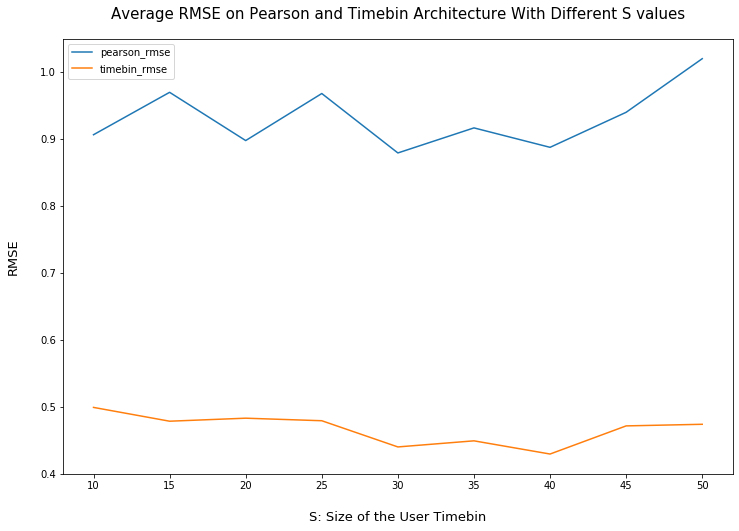

In [49]:
ax = rmse_data.groupby('s').mean().plot(figsize=(12,8))
ax.set_xlabel("S: Size of the User Timebin", labelpad=20, fontsize=13)
ax.set_ylabel("RMSE", labelpad=20, fontsize=13)
ax.set_title("Average RMSE on Pearson and Timebin Architecture With Different S values", pad=20,fontsize=15)
plt.show()

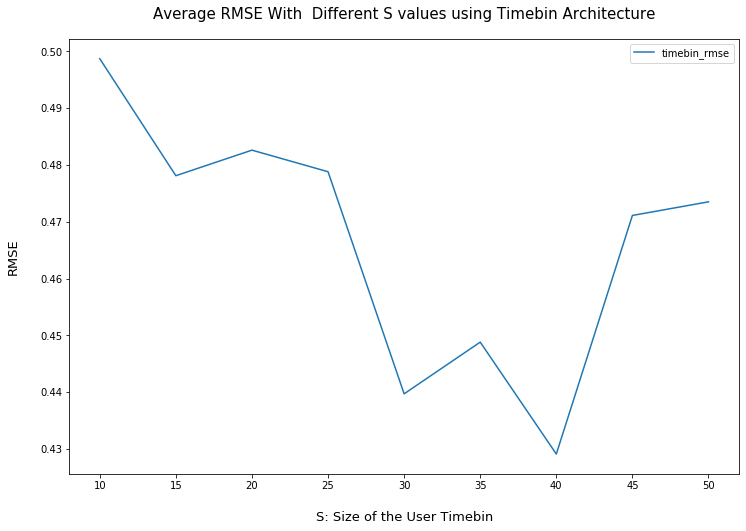

In [50]:
ax = rmse_data[['s','timebin_rmse']].groupby('s').mean().plot(figsize=(12,8))
ax.set_xlabel("S: Size of the User Timebin", labelpad=20, fontsize=13)
ax.set_ylabel("RMSE", labelpad=20, fontsize=13)
ax.set_title("Average RMSE With  Different S values using Timebin Architecture", pad=20,fontsize=15)
plt.show()

### Comparison of Pearson Vs Timebin Architecture in terms of RMSE

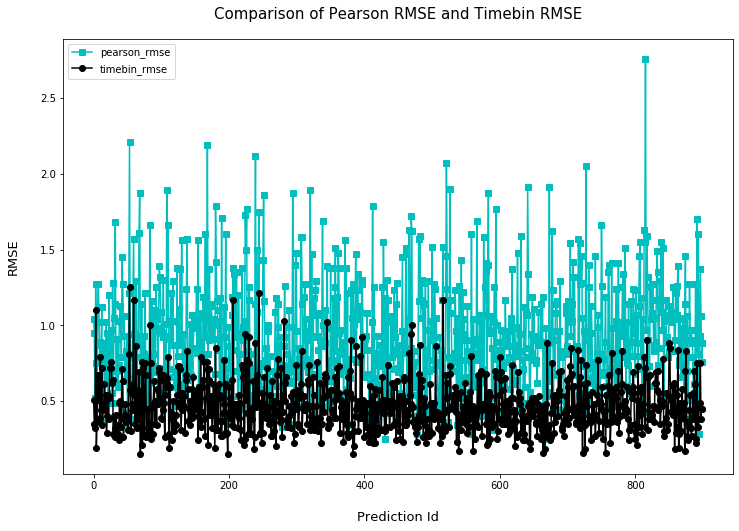

In [51]:
ax = rmse_data[['pearson_rmse', 'timebin_rmse']].plot(figsize=(12,8),style=['cs-','ko-'])
ax.set_xlabel("Prediction Id", labelpad=20, fontsize=13)
ax.set_ylabel("RMSE", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson RMSE and Timebin RMSE", pad=20,fontsize=15)
plt.show()

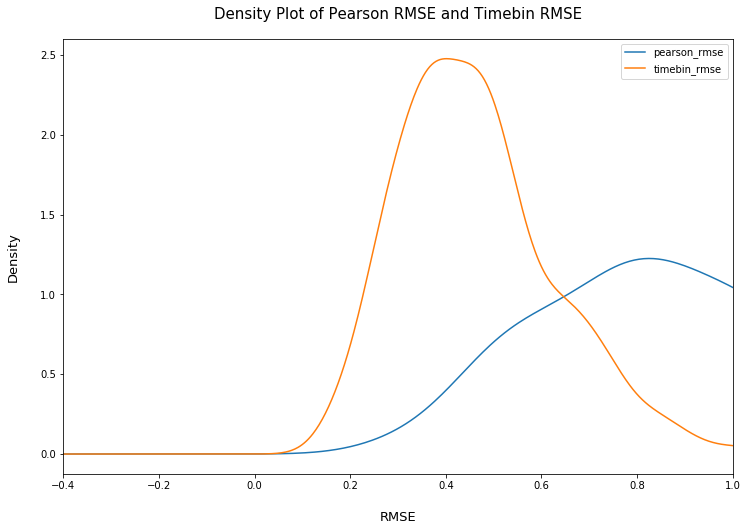

In [52]:
ax = rmse_data[['pearson_rmse', 'timebin_rmse']].plot(figsize=(12,8), kind='density',xlim=[-0.4, 1])
ax.set_xlabel("RMSE", labelpad=20, fontsize=13)
ax.set_ylabel("Density", labelpad=20, fontsize=13)
ax.set_title("Density Plot of Pearson RMSE and Timebin RMSE", pad=20,fontsize=15)
plt.show()

## Threshold Accuracy

Lets just assume that we want to predict whether the user will like the movie or not. Here we predict rating on the movie but we interpret the ratings less than 3.5 as not liked, greater than and equal to 3.5 as liked by the user.

In [55]:
def collect_threshold_accuracy_data(run_results):
    result = list()
    for run in run_results:
        s = run[0]
        normal_accuracy = Accuracy.threshold_accuracy(run[1]['normal_predictions'])
        timebin_accuracy = Accuracy.threshold_accuracy(run[1]['timebin_predictions'])
        result.append( (s, normal_accuracy, timebin_accuracy) )
    df = pd.DataFrame(result)
    df.columns = ['s', 'pearson_threshold_accuracy', 'timebin_threshold_accuracy']
    return df

In [56]:
threshold_data = collect_threshold_accuracy_data(run_results)
threshold_data

,s,pearson_threshold_accuracy,timebin_threshold_accuracy
0,10,0.64,0.84
1,10,0.56,0.80
2,10,0.88,0.84
3,10,0.68,0.72
4,10,0.64,0.88
...,...,...,...
895,50,0.72,0.76
896,50,0.88,0.96
897,50,0.88,0.84
898,50,0.68,0.80


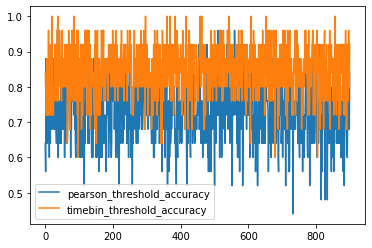

In [57]:
threshold_data[['pearson_threshold_accuracy', 'timebin_threshold_accuracy']].plot()

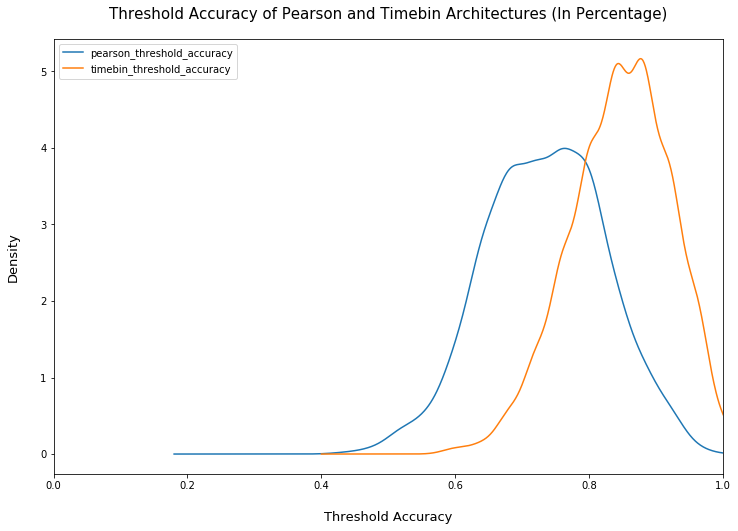

In [60]:
ax = threshold_data[['pearson_threshold_accuracy', 'timebin_threshold_accuracy']].plot(figsize=(12,8), kind='density',xlim=[0, 1])
ax.set_xlabel("Threshold Accuracy", labelpad=20, fontsize=13)
ax.set_ylabel("Density", labelpad=20, fontsize=13)
ax.set_title("Threshold Accuracy of Pearson and Timebin Architectures (In Percentage)", pad=20,fontsize=15)
plt.show()

Here we see that pearson threshold accuracy is taking values in between 40 and 100 and most of the accuracy values are in between 60 and 80.

On the other hand, timebin threshold accuracy is mostly taking values between 60 and 100 and most of the accuracy values are in between 80 and 90.

In [62]:
mean_normal_threshold = threshold_data.mean()['pearson_threshold_accuracy']
mean_timebin_threshold = threshold_data.mean()['timebin_threshold_accuracy']
print(f"Mean Normal Threshold: \t{int(mean_normal_threshold * 100)} %\nMean Timebin Threshold: {int(mean_timebin_threshold * 100)} %")

Mean Normal Threshold: 	73 %
Mean Timebin Threshold: 84 %


## User Coverage

[See this article in order to understand how the coverage is being calculated](https://medium.com/@rishabhbhatia315/recommendation-system-evaluation-metrics-3f6739288870)

In [77]:
def timebin_user_coverage(timebin_similarity:TimebinSimilarity, run_results:list, rating_threshold=0):
    """
    Find user coverage of timebin predictions
    
    If we can make one prediction for the user, than we count the user as covered.
    Result is the number of users we cover divided by all users
    """
    user_ids = defaultdict(bool)   # user ids that we can make prediction
    
    for run in run_results:    
        # Get Run Data
        user_id      = run[1]['output'][1][0]
        timebin_i    = run[1]['output'][1][1]
        timebin_size = run[1]['output'][1][2]
        data         = run[1]['output'][1][3]
        
        # Make timebin based predictions
        prediction = TimebinSimilarity.predict_movie(data, k=10, min_neighbour_count=3)

        if prediction > rating_threshold:
            user_ids[user_id] = True

    return len(user_ids) / 610

In [64]:
def normal_user_coverage(timebin_similarity:TimebinSimilarity, run_results:list, rating_threshold=0):
    user_ids = defaultdict(bool)   # user ids that we can make prediction
    
    for run in run_results:    
        # Get Run Data
        user_id      = run[1]['output'][1][0]
        timebin_i    = run[1]['output'][1][1]
        timebin_size = run[1]['output'][1][2]
        data         = run[1]['output'][1][3]
        
        timebin_of_interest = timebin_similarity.get_timebin2(user_id, timebin_i, timebin_size)
    
        prediction = timebin_similarity.trainset.predict_movie(user_id=user_id, movie_id=movie_id, time_constraint=self.time_constraint)
        
        if prediction > rating_threshold:
            user_ids[user_id] = True
    
    return len(user_ids) / 610

In [ ]:
## Add MovieId to output to calculate pearson coverage
#normal_user_coverage(timebin_similarity, run_results, rating_threshold=0)

In [80]:
timebin_user_coverage(timebin_similarity, run_results, rating_threshold=0)

0.6557377049180327

## Diversity

In [90]:
def timebin_diversity(timebin_similarity:TimebinSimilarity, run_results:list):
    """
    Calculate Timebin Diversity 
    
    We calculate similarity for all the combinations of users and sum them and then divide by the number of combinations. 
    """
    visited_timebins = defaultdict(bool)
    
    n = 0
    total = 0
    
    for run in run_results:
        user_id      = run[1]['output'][1][0]
        timebin_i    = run[1]['output'][1][1]
        timebin_size = run[1]['output'][1][2]
        data         = run[1]['output'][1][3]
        
        for prediction_data in data:
            corr                   = prediction_data[1]
            neighbour_id           = prediction_data[2]
            n_common               = prediction_data[3]
            neighbour_timebin_i    = prediction_data[4]
            neighbour_timebin_size = prediction_data[5]
            timebin_size_in_days   = prediction_data[6]

            key = f"{user_id}_{timebin_i}_{timebin_size}_{neighbour_id}_{neighbour_timebin_i}_{neighbour_timebin_size}"

            if visited_timebins[key] == False:
                total += corr
                n += 1
                visited_timebins[key] = True
    S = total / n
    return (1 - S)

In [91]:
def normal_diversity(timebin_similarity:TimebinSimilarity, run_results:list):
    """
    Calculate Diversity of the results which has been found using pearson correlation 
    
    We calculate similarity for all the combinations of users and sum them and then divide by the number of combinations. 
    """
    visited_user_pairs = defaultdict(bool)
    n = 0
    total = 0
    
    for run in run_results:
        user_id      = run[1]['output'][1][0]
        timebin_i    = run[1]['output'][1][1]
        timebin_size = run[1]['output'][1][2]
        data         = run[1]['output'][1][3]
        neighbours   = timebin_similarity.trainset.get_k_neighbours(user_id)
        
        for neighbour_id, corr in neighbours.iterrows():
            key = f"{user_id}_{neighbour_id}"
            
            if visited_user_pairs[key] == False:
                total += corr[0]
                n += 1
                visited_user_pairs[ key ] = True
    S = total / n
    return (1 - S)

In [93]:
normal_diversity(timebin_similarity, run_results)

0.17185872675264646

In [92]:
timebin_diversity(timebin_similarity, run_results)

0.26440343225132434

In [95]:
def timebin_diversity2(timebin_similarity:TimebinSimilarity, run_results:list):
    """
    Calculate Timebin Diversity 
    
    We calculate similarity for all the combinations of users and sum them and then divide by the number of combinations. 
    """
    visited_user_pairs = defaultdict(bool)
    
    n = 0
    total = 0
    
    for run in run_results:
        user_id      = run[1]['output'][1][0]
        timebin_i    = run[1]['output'][1][1]
        timebin_size = run[1]['output'][1][2]
        data         = run[1]['output'][1][3]

        for prediction_data in data:
            corr                   = prediction_data[1]
            neighbour_id           = prediction_data[2]
            n_common               = prediction_data[3]
            neighbour_timebin_i    = prediction_data[4]
            neighbour_timebin_size = prediction_data[5]
            timebin_size_in_days   = prediction_data[6]

            key = f"{user_id}_{neighbour_id}"

            if visited_user_pairs[key] == False:
                total += corr
                n += 1
            visited_user_pairs[ key ] = True
    S = total / n
    return (1 - S)

In [96]:
timebin_diversity2(timebin_diversity, run_results)

0.3167987445023228